In [48]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neural_network import MLPClassifier  # Import neural network model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict

In [21]:
# Load data
train_df = pd.read_csv('24_train_3.csv')
test_df = pd.read_csv('news-test-1.csv')

# Extract text and labels
X_train_raw = train_df["Text"]
y_train = train_df["Category"]
X_test_raw = test_df["Text"]

In [28]:
# 1a Preprocess training data CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
X_train_count = count_vectorizer.fit_transform(X_train_raw)  #the long article text
print(X_train_count.shape)

(1000, 5000)


In [23]:
# 1a test data
X_test_count = count_vectorizer.transform(X_test_raw)
print(X_test_count.shape)

(680, 5000)


In [32]:
# 1b Preprocess training data TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)  #the long article text
print(X_train_tfidf.shape)

(1000, 5000)


In [33]:
# 1b test data
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)
print(X_test_tfidf.shape)

(680, 5000)


1c Describe how you generate features

Feature generation is the process of transforming raw text (news articles) into a numerical representation that a machine learning model can understand.

Feature extraction methods used:
1. CountVectorizer (Bag of Words)
- Converts each document into a word frequency matrix, where:
  - Rows represent documents.
  - Columns represent words (tokens).
  - Values indicate how many times each word appears in a document.
- Advantages: Simple and interpretable. Works well when word order isn’t important.
- Disadvantages: Ignores word meaning and relationships. Large vocabulary size can increase memory usage.

2. TF-IDF (Term Frequency-Inverse Document Frequency)
- Unlike CountVectorizer, TF-IDF assigns higher importance to rare words and reduces the influence of very common words.
- Calculation: TF-IDF = Term Frequency * log(Total Documents / Documents Containing the Word)
- Advantages: Reduces the impact of common words. Works well when distinguishing important vs. unimportant words.
- Disadvantages: Still ignores word meaning and relationships. Can be sensitive to spelling variations.

3. Word Embeddings (GloVe)
- Unlike CountVectorizer and TF-IDF, GloVe represents words as dense numerical vectors that capture semantic meaning. (e.g. King - Man + Woman ≈ Queen)
- Advantages: Captures word meaning & relationships. Works well with deep learning models. Handles synonyms & semantic similarities.
- Disadvantages: Requires pre-trained embeddings. Can be computationally expensive.
- Key Settings: Pre-trained embeddings (glove-wiki-gigaword-50) with 50-dimensional word vectors. Convert each document into a vector by averaging word embeddings.


Key settings used for both CountVectorizer and TF-IDF:
- max_features=5000: Only keep the top 5,000 most frequent words to limit vocabulary to most frequent 5,000 words, reducing sparsity.
- stop_words='english': Remove common stopwords (e.g., the, is, and), reducing noise.
- ngram_range=(1,2): Use both single words (unigrams) and word pairs (bigrams) for context (e.g., “new” vs. “new york”).

In [64]:
# 1d
kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross-validation

feature_methods = {
    "CountVectorizer": X_train_count,
    "TF-IDF": X_train_tfidf,
    # "Word Embeddings (GloVe)": X_train_glove
}
results = []  # Dictionary to store results

model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42)  # Using MLP for neural network

# Loop through feature extraction methods
for name, X_train_feat in feature_methods.items():

    # Perform cross-validation (Training Accuracy)
    cv_results = cross_validate(model, X_train_feat, y_train, cv=kf, scoring="accuracy", return_train_score=True)

    train_accuracies = cv_results['train_score']
    val_accuracies = cv_results['test_score']
    print(name, train_accuracies, val_accuracies)

    # Compute mean & std deviation
    mean_train_acc = np.mean(train_accuracies)
    std_train_acc = np.std(train_accuracies)
    mean_val_acc = np.mean(val_accuracies)
    std_val_acc = np.std(val_accuracies)

    results.append({
        "Feature Method": name,
        "Mean Training Accuracy": round(mean_train_acc, 3),
        "Std Training Accuracy": round(std_train_acc, 3),
        "Mean Validation Accuracy": round(mean_val_acc, 3),
        "Std Validation Accuracy": round(std_val_acc, 3)
    })

results_df = pd.DataFrame(results)  # Convert results to DataFrame
results_df

CountVectorizer [1. 1. 1. 1. 1.] [0.955 0.97  0.975 0.99  0.965]
TF-IDF [1. 1. 1. 1. 1.] [0.955 0.98  0.975 0.985 0.965]


,Feature Method,Mean Training Accuracy,Std Training Accuracy,Mean Validation Accuracy,Std Validation Accuracy
0,CountVectorizer,1.0,0.0,0.971,0.012
1,TF-IDF,1.0,0.0,0.972,0.011


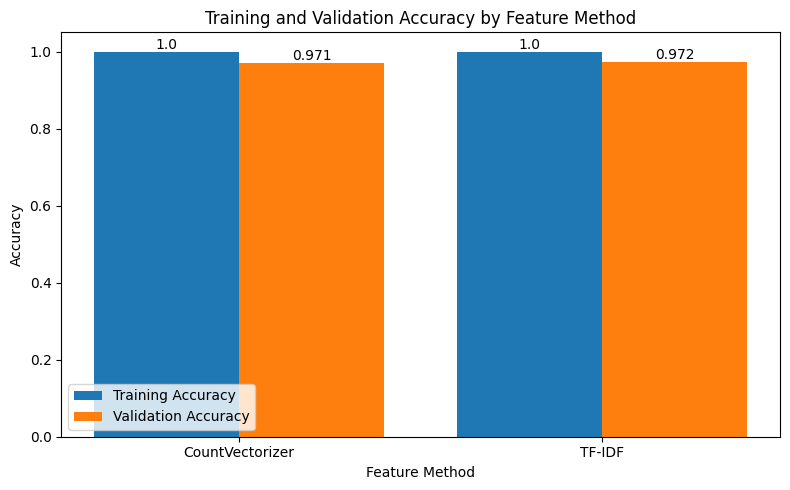

In [69]:
# 1e bar figure: training and validation results

plt.figure(figsize=(8, 5))
bar_width = 0.4
indices = np.arange(len(results_df))  # Number of feature methods

# Plot bars
bars1 = plt.bar(indices, results_df['Mean Training Accuracy'], bar_width, label='Training Accuracy')
bars2 = plt.bar(indices + bar_width, results_df['Mean Validation Accuracy'], bar_width, label='Validation Accuracy')

# Add labels, title, and x-axis ticks
plt.xlabel('Feature Method')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy by Feature Method')
plt.xticks(indices + bar_width / 2, results_df['Feature Method'])
plt.legend()

# Annotate the bars with the accuracy values on top
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

2a Describe your parameter setting

model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42)

1. hidden_layer_sizes=(128, 128)
- This defines a neural network with 2 hidden layers, each containing 128 neurons.
- More hidden layers help the model learn complex patterns, and 128 neurons per layer provide a balance between learning capacity and efficiency.

2. max_iter=1000
- The model will train for up to 1000 iterations (epochs) or until convergence.
- More iterations allow the neural network to adjust weights for better learning.

3. random_state=42
- Ensures reproducibility by setting a fixed random seed.

In [76]:
# 2b1 table
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
results2 = []

# Loop through different learning rates
for eta in learning_rates:
    model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42, learning_rate_init=eta)

    # Perform cross-validation
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=kf, scoring="accuracy", return_train_score=True)

    train_accuracies = cv_results['train_score']
    val_accuracies = cv_results['test_score']

    # Compute mean & standard deviation
    mean_train_acc = np.mean(train_accuracies)
    std_train_acc = np.std(train_accuracies)
    mean_val_acc = np.mean(val_accuracies)
    std_val_acc = np.std(val_accuracies)

    results2.append({
        "Learning Rate": eta,
        "Mean Training Accuracy": round(mean_train_acc, 3),
        "Std Training Accuracy": round(std_train_acc, 3),
        "Mean Validation Accuracy": round(mean_val_acc, 3),
        "Std Validation Accuracy": round(std_val_acc, 3)
    })
    print(eta)

# Convert results to DataFrame
results2_df = pd.DataFrame(results2)
results2_df

0.0001
0.0003
0.001
0.003
0.01
0.03
0.1


,Learning Rate,Mean Training Accuracy,Std Training Accuracy,Mean Validation Accuracy,Std Validation Accuracy
0,0.0001,1.0,0.0,0.973,0.010
1,0.0003,1.0,0.0,0.972,0.011
2,0.0010,1.0,0.0,0.972,0.011
3,0.0030,1.0,0.0,0.976,0.007
4,0.0100,1.0,0.0,0.964,0.019
5,0.0300,1.0,0.0,0.951,0.017
6,0.1000,1.0,0.0,0.947,0.015


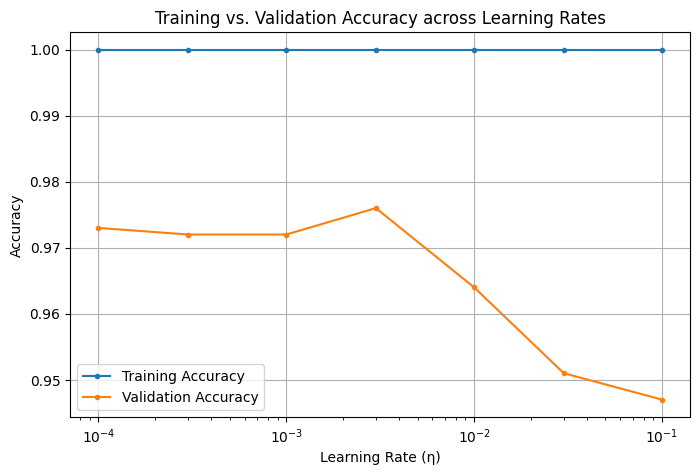

In [78]:
# 2b2 line figure

learning_rates = results2_df["Learning Rate"]
train_accuracies = results2_df["Mean Training Accuracy"]
val_accuracies = results2_df["Mean Validation Accuracy"]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, train_accuracies, marker='.', label='Training Accuracy')
plt.plot(learning_rates, val_accuracies, marker='.', label='Validation Accuracy')

# Labels and Title
plt.xscale("log")  # Log scale for better visualization
plt.xlabel("Learning Rate (η)")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy across Learning Rates")
plt.legend()
plt.grid(True)

plt.show()

In [82]:
# 2c1 table
optimizers = ["sgd", "adam", "lbfgs"]
results3 = []

for optimizer in optimizers:
    model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, solver=optimizer, random_state=42)

    # Perform cross-validation
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=kf, scoring="accuracy", return_train_score=True)

    train_accuracies = cv_results['train_score']
    val_accuracies = cv_results['test_score']

    # Compute mean & std deviation
    mean_train_acc = np.mean(train_accuracies)
    std_train_acc = np.std(train_accuracies)
    mean_val_acc = np.mean(val_accuracies)
    std_val_acc = np.std(val_accuracies)

    results3.append({
        "Optimizer": optimizer.upper(),
        "Mean Training Accuracy": round(mean_train_acc, 3),
        "Std Training Accuracy": round(std_train_acc, 3),
        "Mean Validation Accuracy": round(mean_val_acc, 3),
        "Std Validation Accuracy": round(std_val_acc, 3)
    })
    print(optimizer)

# Convert results to DataFrame
results3_df = pd.DataFrame(results3)
results3_df

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

sgd
adam
lbfgs


,Optimizer,Mean Training Accuracy,Std Training Accuracy,Mean Validation Accuracy,Std Validation Accuracy
0,SGD,0.988,0.001,0.963,0.017
1,ADAM,1.000,0.000,0.972,0.011
2,LBFGS,1.000,0.000,0.966,0.012


In [88]:
print(results3_df)

  Optimizer  Mean Training Accuracy  Std Training Accuracy  \
0       SGD                   0.988                  0.001   
1      ADAM                   1.000                  0.000   
2     LBFGS                   1.000                  0.000   

   Mean Validation Accuracy  Std Validation Accuracy  
0                     0.963                    0.017  
1                     0.972                    0.011  
2                     0.966                    0.012  


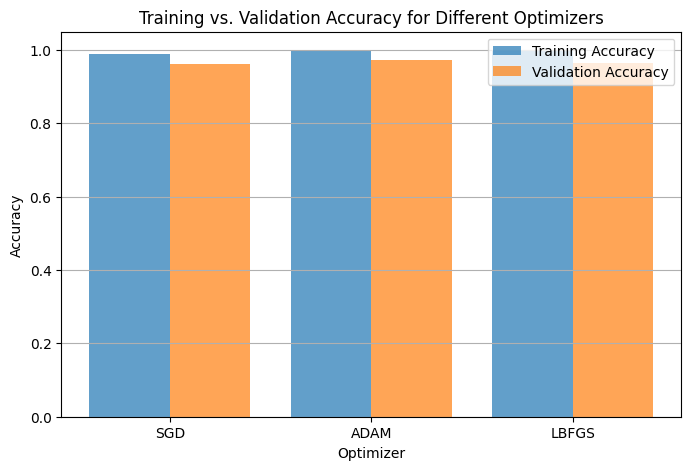

In [83]:
# 2c2 bar figure

optimizers = results3_df["Optimizer"]
train_accuracies = results3_df["Mean Training Accuracy"]
val_accuracies = results3_df["Mean Validation Accuracy"]

plt.figure(figsize=(8, 5))
bar_width = 0.4
indices = np.arange(len(optimizers))

# Plot training and validation bars
plt.bar(indices, train_accuracies, bar_width, label="Training Accuracy", alpha=0.7)
plt.bar(indices + bar_width, val_accuracies, bar_width, label="Validation Accuracy", alpha=0.7)

# Labels and Title
plt.xticks(indices + bar_width / 2, optimizers)
plt.xlabel("Optimizer")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy for Different Optimizers")
plt.legend()
plt.grid(axis="y")

plt.show()

3a Describe how you pre-process the data to generate features.

1. Text Tokenization & Vectorization
- Used CountVectorizer and TF-IDF (Term Frequency-Inverse Document Frequency) to convert text into numerical features.
- CountVectorizer: Represents text based on word frequency.
- TF-IDF: Weighed word frequency relative to its importance across documents.

2. Feature Selection
- Compared both CountVectorizer and TF-IDF to determine which provided better accuracy.
- Results show TF-IDF performed slightly better (97.2% validation accuracy vs. 97.1%), so we used TF-IDF as the final feature representation.

3. Data Splitting
- Divided the dataset into training and validation sets to evaluate generalization.


Key settings used:
- max_features=5000: Only keep the top 5,000 most frequent words to limit vocabulary to most frequent 5,000 words, reducing sparsity.
- stop_words='english': Remove common stopwords (e.g., the, is, and), reducing noise.
- ngram_range=(1,2): Use both single words (unigrams) and word pairs (bigrams) for context (e.g., “new” vs. “new york”).


3b Describe how you choose the model and parameters

I chose model `MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, solver="adam", random_state=42, learning_rate_init=0.003)`

- TF-IDF feature method has the highest mean validation accuracy of 0.972.
- 0.003 learning rate has the highest mean validation accuracy of 0.976.
- Adam optimizer has the highest mean validation accuracy of 0.972.


3c Describe the performance of your chosen model and parameter on the training data.

| Feature Method   | Mean Training Accuracy | Mean Validation Accuracy | Std Validation Accuracy |
|------------------|------------------------|--------------------------|-------------------------|
| **CountVectorizer** | 1.000 | 0.971 | 0.012 |
| **TF-IDF**        | 1.000 | **0.972** | 0.011 |


| Learning Rate | Mean Training Accuracy | Mean Validation Accuracy | Std Validation Accuracy |
|---------------|------------------------|--------------------------|-------------------------|
| 0.0001        | 1.000 | 0.973 | 0.010 |
| 0.0003        | 1.000 | 0.972 | 0.011 |
| 0.0010        | 1.000 | 0.972 | 0.011 |
| **0.0030**    | 1.000 | **0.976** | 0.007 |
| 0.0100        | 1.000 | 0.964 | 0.019 |
| 0.0300        | 1.000 | 0.951 | 0.017 |
| 0.1000        | 1.000 | 0.947 | 0.015 |


| Optimizer  | Mean Training Accuracy | Mean Validation Accuracy | Std Validation Accuracy |
|------------|------------------------|--------------------------|-------------------------|
| **SGD**    | 0.988 | 0.963 | 0.017 |
| **Adam**   | 1.000 | **0.972** | 0.011 |
| **LBFGS**  | 1.000 | 0.966 | 0.012 |

Observations:
- Perfect training accuracy (1.000) across all configurations suggests possible overfitting.
- Adam optimizer with learning rate 0.003 and TF-IDF features gave the best validation accuracy (97.6%).
- The low standard deviation (0.007) indicates the model's predictions are stable.

In [85]:
# 3 Predict the labels for the testing data
article_ids = test_df['ArticleId']

model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, solver="adam", random_state=42, learning_rate_init=0.003)
model.fit(X_train_tfidf, y_train)     # Train the model on the training data
pred_y = model.predict(X_test_tfidf)  # Predict the labels for the testing data

# Save predictions to labels.csv
labels_df = pd.DataFrame(list(zip(article_ids, pred_y)))
labels_df.to_csv("labels.csv", index=False, header=False)